In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import NMF

np.random.seed(42)
np.set_printoptions(precision=3)

In [ ]:
def load_results(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['hscores'], data['total_scores']

def plot_combined_H(H, img_size, figsize, num_rows=1, filename=None):
    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')

    if num_rows > 1:
        num_cols = int(np.ceil(H.shape[0] / num_rows))
        large_mat = np.vstack([np.hstack(H3d[i * num_cols: (i+1) * num_cols]) for i in range(num_rows)])
    else:
        large_mat = np.hstack(H3d)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(large_mat, cmap='gray')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')

    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        plt.close()


def plot_W_mats(W, figsize, fontsize, n_rows=1, filename=None, scale_y=False, plot_title=None):
    rank = W.shape[1]
    wmin, wmax = np.min(W), np.max(W)

    n_cols = int(np.ceil(rank / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    axs = axs.ravel()

    for cnt, ax in enumerate(axs):
        if cnt < rank:
            ax.plot(W[:, cnt], linewidth=3)
            if scale_y:
                ax.set_ylim([min(0, wmin), wmax])

            ax.set_title(f'$w_{{{cnt + 1}}}$', fontsize=fontsize)
            ax.set_xlabel('Bands')
            ax.set_ylabel('Reflectance')
        else:
            ax.axis('off')

    plt.tight_layout()
    if plot_title:
        fig.suptitle(plot_title, fontsize=25)
    if filename:
        fig.savefig(filename)
        plt.close()

## Region selection

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot the matrix with imshow
# img = plt.imshow(jasper_3d[80, :, :], cmap='gray')
img = plt.imread('old/resized_image.png')

# Plot the image with imshow
plt.imshow(img)
# Add a rectangular box around the region of interest
rect1 = patches.Rectangle((0, 62), 8, 8, linewidth=2, edgecolor='r', facecolor='none') # jasper_small_6
rect2 = patches.Rectangle((30, 10), 10, 10, linewidth=2, edgecolor='r', facecolor='none') # jasper_small_2
rect3 = patches.Rectangle((0, 0), 99, 99, linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangles to the plot
ax = plt.gca()
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

# Add numbering to the rectangles
ax.text(-4, 67, "1", color='r', fontsize=30, ha='center', va='center')
ax.text(35, 16, "2", color='r', fontsize=30, ha='center', va='center')
ax.text(106, 98, "3", color='r', fontsize=30, ha='right', va='bottom')

# Turn off the axis labels and tick marks
ax.axis(False)

# Adjust the layout of the plot
plt.tight_layout()

# Show the plot
# plt.show()
# plt.savefig('../for_article/regions_over_img.pdf')

## Synthetic

In [ ]:
def plot_3d(ax, X, Wt, W):
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[0, :], X[1, :], X[2, :], c='lightblue', marker='o')
    ax.scatter(Wt[0, :], Wt[1, :], Wt[2, :], c='red', marker='o', s=144)
    ax.scatter(W[0, :], W[1, :], W[2, :], c='black', marker='x', s=144)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    # ax.legend(['Data points', 'True W', 'Estimated W'])
    ax.grid(True)
    # plt.tight_layout()
    # if filepath:
    #     plt.savefig(filepath)
    # else:
    #     plt.show()

In [ ]:
data_filepath = '../datasets/synthetic_data.npz'

data = np.load(data_filepath)
M = data['M']
W_true = data['W_true']
H_true = data['H_true']

In [ ]:
row_labels = ['Rank 4', 'Rank 8']
col_labels = ['Vanilla NMF', 'Vanilla NMF (L2 norm adjusted)', 'SONNMF']

fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, len(col_labels) + 1, width_ratios=[0.02] + len(col_labels) * [1], hspace=0.1)

for i, rlabel in enumerate(row_labels):
    txt_ax = fig.add_subplot(gs[i, 0])
    txt_ax.text(0.5, 0.5, rlabel, ha='center', va='center', fontsize=14)
    txt_ax.axis('off')

r = 4
vW1 = np.load('../saved_models/synthetic/vanilla_r{}_it{}.npz'.format(r, 10000))['W']
col_norm_vW1 = np.linalg.norm(vW1, axis=0, ord=2, keepdims=True)
vW1_re = vW1 / col_norm_vW1
# vH1_re = vH1 * col_norm_vW1.T
cW1, _, _, _, _, _ = load_results('../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'.format(r, 0.001, 0.1, 10000))

for i, curr_W in enumerate([vW1, vW1_re, cW1]):
    curr_subplot = fig.add_subplot(gs[0, i+1], projection='3d')
    plot_3d(curr_subplot, M, W_true, curr_W)
    curr_subplot.set_title(col_labels[i], fontsize=14)


r = 8
vW2 = np.load('../saved_models/synthetic/vanilla_r{}_it{}.npz'.format(r, 1000))['W']
col_norm_vW2 = np.linalg.norm(vW2, axis=0, ord=2, keepdims=True)
vW2_re = vW2 / col_norm_vW2
# vH2_re = vH2 * col_norm_vW2.T
cW2, _, _, _, _, _ = load_results('../saved_models/synthetic/5x_r{}_l{}_g{}_it{}.npz'.format(r, 0.01, 0.5, 1000))

for i, curr_W in enumerate([vW2, vW2_re, cW2]):
    plot_3d(fig.add_subplot(gs[1, i+1], projection='3d'), M, W_true, curr_W)
fig.legend(['Data points', 'True W', 'Estimated W'],
                 bbox_to_anchor=(0.2, 0.9, 0, 0))
fig.subplots_adjust(wspace=0.)
# plt.savefig('../for_article/synthetic_vanilla_vs_sonnmf.pdf')

In [ ]:
ini_filepath = '../saved_models/synthetic/r{}_ini.npz'
save_filepath = '../saved_models/synthetic/5x_r{}_l{}_g{}_it{}.npz'

fig = plt.figure(figsize=(16, 5))
axs = [fig.add_subplot(1, 4, i+1, projection='3d') for i in range(4)]


data = np.load(ini_filepath.format(r))
ini_W = data['ini_W'] * 5
ini_H = data['ini_H']
plot_3d(axs[0], M, W_true, ini_W)
axs[0].set_title('Initial')


# Loop over iterations and plot W using plot_3d function
for i, it in enumerate([10, 100, 1000]):
    W, _, _, _, _, _ = load_results(save_filepath.format(r, 0.01, 0.5, it))
    plot_3d(axs[i+1], M, W_true, W)
    axs[i+1].set_title('{} iterations'.format(it))
fig.legend(['Data points', 'True W', 'Estimated W'],
                 bbox_to_anchor=(0.97, 0.85, 0, 0))
# plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.2)
# plt.savefig('../for_article/synthetic_r8_iterations.pdf')

## jasper small 1 (10x10) - region 1

In [ ]:
data_filepath = '../datasets/jasper_small_1.npz'
ini_filepath = '../saved_models/jasper_small_1/r{}_ini.npz'

In [ ]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)
m, n = M.shape
r = n

In [ ]:
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [ ]:
W, H, fscores, gscores, hscores, total_scores = load_results('../saved_models/jasper_small_1/r100_l1000_g0.001_it1000.npz')

In [ ]:
# plt.imshow(np.corrcoef(W, rowvar=False), 'gray')
# plt.colorbar()
# plt.tight_layout()

In [ ]:
wmin, wmax = np.min(W), np.max(W)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.set_xlabel('Bands')
ax.set_ylabel('Reflectance')
ax.set_ylim([min(0, wmin), wmax])
ax.grid(which='both', linewidth=0.5, color='lightgrey')
# ax.minorticks_on()
ax.plot(W, linewidth=1)
ax.set_title('$w_{{all}}$', fontsize=18, x=0.5, y=0.87)

# Adjust layout and display plot
plt.tight_layout()
# plt.savefig('../for_article/jasper_region_2_w_overlapped.pdf')

/Users/waqas/opt/anaconda3/envs/sonnmf/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/waqas/opt/anaconda3/envs/sonnmf/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


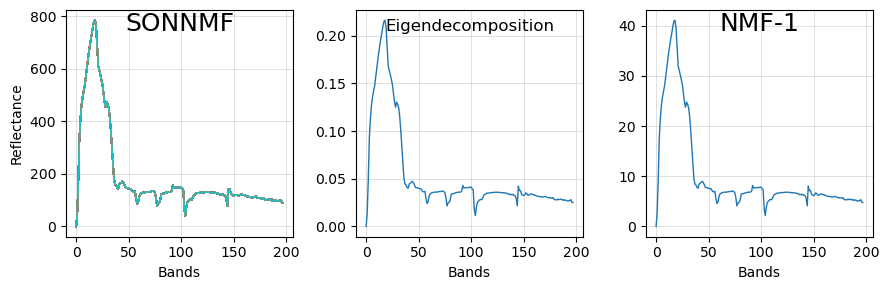

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
axs = axs.ravel()

for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    # ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


axs[0].plot(W, linewidth=1)
axs[0].set_title('SONNMF', fontsize=18, x=0.5, y=0.87)

w, v = np.linalg.eig(M @ M.T)
axs[1].plot(v[:, 0], linewidth=1)
axs[1].set_title('Eigendecomposition', fontsize=12, x=0.5, y=0.87)


model = NMF(n_components=1, random_state=42, max_iter=1000)
W_NMF = model.fit_transform(X=M)
axs[2].plot(W_NMF, linewidth=1)
axs[2].set_title('NMF-1', fontsize=18, x=0.5, y=0.87)


# Adjust layout and display plot
plt.tight_layout()
plt.savefig('../for_article/jasper_region_1_w_comp.pdf')

## jasper small 2 (8x8) - region 2

In [ ]:
W, H, fscores, gscores, hscores, total_scores = load_results('../saved_models/jasper_small_2/r64_l40000_g10000_it2000.npz')

In [ ]:
plt.imshow(np.corrcoef(W, rowvar=False), 'gray')
plt.colorbar()
plt.tight_layout()
# plt.savefig('/Users/waqas/Desktop/nmfson_results/jasper_small/correlation_matrix.png')

In [ ]:
unique_idxs = [17]
unique_labels = ['soil']
other_idxs = [x for x in range(64) if x not in unique_idxs]

In [ ]:
wmin, wmax = np.min(W), np.max(W)


fig, axs = plt.subplots(1, len(unique_idxs) + 1, figsize=(6, 3), sharex=True, sharey=True)
axs = axs.ravel()


for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


for ax_idx, w_idx in enumerate(unique_idxs):
    axs[ax_idx].plot(W[:, w_idx], linewidth=2)
    axs[ax_idx].set_title(f'$w_{{{w_idx}}}$', fontsize=14, x=0.92, y=0.87)

axs[-1].plot(W[:, other_idxs], linewidth=0.5)
axs[-1].set_title('$w_{{-17}}$', fontsize=14, x=0.89, y=0.87)

# Adjust layout and display plot
plt.tight_layout()
plt.savefig('../for_article/jasper_region_1_w_overlapped.pdf')

In [ ]:
# sum
hsum = H[other_idxs, :].sum(axis=0, keepdims=True)
wsum = W[:, other_idxs].sum(axis=1, keepdims=True)

new_W = np.hstack((W[:, unique_idxs], wsum))
new_H = np.vstack((H[unique_idxs, :], hsum))

In [ ]:
plot_combined_H(new_H, (8, 8), (6, 3), num_rows=1, filename='../for_article/jasper_region_1_h_summed.pdf')

## jasper full (100x100) - full

In [ ]:
W, H, fscores, gscores, hscores, total_scores = load_results('../saved_models/jasper_full/r20_l1000000_g1000000_it1000.npz')

In [ ]:
plt.imshow(np.corrcoef(W, rowvar=False), 'gray')
plt.colorbar()
plt.tight_layout()
# plt.savefig('/Users/waqas/Desktop/nmfson_results/jasper_small/correlation_matrix.png')

In [ ]:
unique_idxs = [6, 8, 14]
unique_labels = ['water', 'tree', 'soil']
other_idxs = [x for x in range(20) if x not in unique_idxs]

In [ ]:
wmin, wmax = np.min(W), np.max(W)


fig, axs = plt.subplots(1, len(unique_idxs) + 1, figsize=(12, 3), sharex=True, sharey=True)
axs = axs.ravel()


for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


for ax_idx, w_idx in enumerate(unique_idxs):
    axs[ax_idx].plot(W[:, w_idx], linewidth=2)
    axs[ax_idx].set_title(f'$w_{{{w_idx}}}$', fontsize=14, x=0.92, y=0.87)

axs[-1].plot(W[:, other_idxs], linewidth=0.5)
axs[-1].set_title('$w_{-{\{6, 8, 14\}}}$', fontsize=14, x=0.80, y=0.87)

# Adjust layout and display plot
plt.tight_layout()
plt.savefig('../for_article/jasper_full_w_overlapped.pdf')

In [ ]:
# sum
hsum = H[other_idxs, :].sum(axis=0, keepdims=True)
wsum = W[:, other_idxs].sum(axis=1, keepdims=True)

new_W = np.hstack((W[:, unique_idxs], wsum))
new_H = np.vstack((H[unique_idxs, :], hsum))

In [ ]:
plot_combined_H(new_H, (100, 100), (12, 3), num_rows=1, filename='../for_article/jasper_full_h_summed.pdf')